In [1]:
import config
from src import load_data

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, GRU

from tensorflow.keras.metrics import MeanAbsoluteError as mae
from tensorflow.keras.metrics import MeanAbsolutePercentageError as mape

sns.set_theme(style='whitegrid')

2025-01-08 12:05:02.553271: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/lucascaio/Desktop/Fac/Master/M2/Bloc fondamental/Apprentissage sequentiel pour la prevision de series temporelles/appliances-energy-prediction/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# RMSE (Root Mean Squared Error)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred), axis=-1))

In [3]:
data = load_data(config.PROCESSED_DATA_FILE)

Données chargées avec succès.


In [4]:
train_size = 15415
test_size = len(data) - train_size

raw_data_train = data[:train_size]
raw_data_test = data[train_size:].reset_index(drop=True)

data_train = data[:train_size].Appliances.values.reshape(-1, 1)
data_test = data[train_size:].Appliances.values.reshape(-1, 1)

In [5]:
raw_data_test.shape

(4320, 41)

In [6]:
scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(data_train)
scaled_test = scaler.fit_transform(data_test)

In [7]:
lag_size = 144
horizon = 144

X_train = []
y_train = []
X_test = []
y_test = []

# Créer les données d'entraînement
for i in range(lag_size, len(scaled_train) - horizon):  # On s'assure de ne pas sortir des bornes
    X_train.append(scaled_train[i - lag_size:i, 0])  # 144 périodes précédentes
    y_train.append(scaled_train[i:i + horizon, 0])  # Consommation sur les 144 périodes suivantes

X_train, y_train = np.array(X_train), np.array(y_train)

# Créer les données de test
for i in range(lag_size, len(scaled_test) - horizon):
    print(i)
    X_test.append(scaled_test[i - lag_size:i, 0])  # 144 périodes précédentes
    y_test.append(scaled_test[i:i + horizon, 0])  # Consommation sur les 144 périodes suivantes

X_test, y_test = np.array(X_test), np.array(y_test)

144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393


In [8]:
len(scaled_test) - horizon - lag_size

4032

In [9]:
X_test.shape

(4032, 144)

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [11]:
validation_size = int(0.3 * len(X_train))

X_train_new = X_train[:-validation_size]
y_train_new = y_train[:-validation_size]
X_val = X_train[-validation_size:]
y_val = y_train[-validation_size:]

In [12]:
# Modèle RNN
rnn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(50, activation='tanh'),
    Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mse', metrics=[mae, mape, rmse])

In [13]:
batch_size = 32
epochs = 5

history_rnn = rnn_model.fit(X_train_new, y_train_new, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/5
331/331 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 0.0148 - mean_absolute_error: 0.0752 - mean_absolute_percentage_error: 76932.5156 - rmse: 0.1077 - val_loss: 0.0084 - val_mean_absolute_error: 0.0549 - val_mean_absolute_percentage_error: 89.6637 - val_rmse: 0.0835
Epoch 2/5
331/331 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0103 - mean_absolute_error: 0.0622 - mean_absolute_percentage_error: 69255.1562 - rmse: 0.0953 - val_loss: 0.0084 - val_mean_absolute_error: 0.0517 - val_mean_absolute_percentage_error: 80.0239 - val_rmse: 0.0825
Epoch 3/5
331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0104 - mean_absolute_error: 0.0620 - mean_absolute_percentage_error: 68678.6562 - rmse: 0.0953 - val_loss: 0.0084 - val_mean_absolute_error: 0.0531 - val_mean_absolute_percentage_error: 84.5106 - val_rmse: 0.0830
Epoch 4/5
331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0105 - mean_absolute_error: 0.0627 - mean_absolute_percentage_error: 68050.2500 - rmse: 0.0962 - val_loss: 0.008

In [14]:
rnn_mse, rnn_mae, rnn_mape, rnn_rmse = rnn_model.evaluate(X_test, y_test)

print(f"RNN MSE: {rnn_mse}")
print(f"RNN MAE: {rnn_mae}")
print(f"RNN MAPE: {rnn_mape}")
print(f"RNN RMSE: {rnn_rmse}")

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0130 - mean_absolute_error: 0.0623 - mean_absolute_percentage_error: 705899.0000 - rmse: 0.1046
RNN MSE: 0.011837253347039223
RNN MAE: 0.05879851058125496
RNN MAPE: 348885.25
RNN RMSE: 0.09832289814949036


In [26]:
pred_train = rnn_model.predict(X_train)
pred_test = rnn_model.predict(X_test)

# pred_train = scaler.inverse_transform(pred_train)
# pred_test = scaler.inverse_transform(pred_test)

473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [16]:
len(pred_test.flatten())

4032

In [17]:
raw_data_test['test_forecast'] = np.NaN
raw_data_test.loc[lag_size: lag_size - horizon, 'test_forecast']

Series([], Name: test_forecast, dtype: float64)

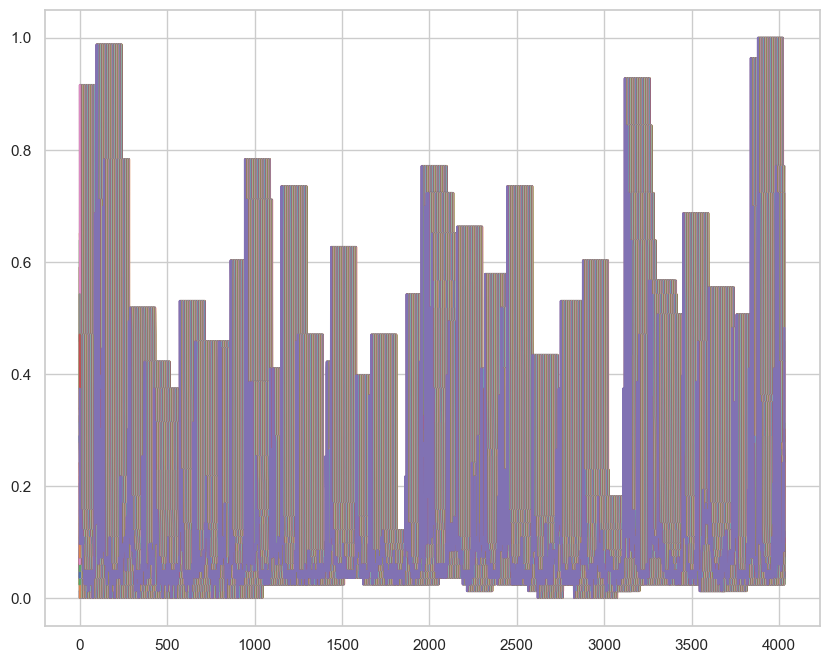

In [27]:
plt.figure(figsize=(10, 8))

plt.plot(pred_test)
plt.plot(y_test)

plt.show()

In [18]:
raw_data_train['train_forecast'] = np.NaN
raw_data_train.loc[lag_size: len(data_train) - horizon - 1, 'train_forecast'] = pred_train.flatten()

raw_data_test['test_forecast'] = np.NaN
raw_data_test.loc[lag_size: len(data_test) - horizon - 1, 'test_forecast'] = pred_test.flatten()

/var/folders/b_/ysnxfskx5fgbfx24s4__pj_h0000gn/T/ipykernel_1818/1758020451.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_train['train_forecast'] = np.NaN
